


---


#1. Dataset Selection

---




In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d marquis03/plants-classification

Dataset URL: https://www.kaggle.com/datasets/marquis03/plants-classification
License(s): Apache 2.0
 99% 1.33G/1.34G [00:15<00:00, 32.2MB/s]
100% 1.34G/1.34G [00:15<00:00, 95.6MB/s]


In [ ]:
!unzip /content/plants-classification.zip

Archive:  /content/plants-classification.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 



---


# 2. Transfer Learning Implementation
---



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import classification_report

> Preprocess the selected dataset

In [ ]:
train_data_dir = '/content/train1'
validation_data_dir = '/content/val1'
test_data_dir = '/content/test1'

> Data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Define batch size and number of training samples
batch_size = 32
train_samples = 1000
validation_samples = 500

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 2800 images belonging to 5 classes.
Found 400 images belonging to 5 classes.
Found 800 images belonging to 5 classes.


> Choose a pre-trained deep learning model ( VGG16)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


> Implement transfer learning

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

> Freeze the base model layers

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

> Train the transferred model

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define the filepath where you want to save the weights
filepath = "model_weights.h5"

# Define the checkpoint
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Compile the model and include the checkpoint
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=[checkpoint])


Epoch 1/10
88/88 [==============================] - ETA: 0s - loss: 0.8637 - accuracy: 0.7004
Epoch 1: val_accuracy improved from -inf to 0.85250, saving model to model_weights.h5
88/88 [==============================] - 46s 508ms/step - loss: 0.8637 - accuracy: 0.7004 - val_loss: 0.5308 - val_accuracy: 0.8525
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - ETA: 0s - loss: 0.5318 - accuracy: 0.8114
Epoch 2: val_accuracy did not improve from 0.85250
88/88 [==============================] - 42s 476ms/step - loss: 0.5318 - accuracy: 0.8114 - val_loss: 0.5355 - val_accuracy: 0.8375
Epoch 3/10
88/88 [==============================] - ETA: 0s - loss: 0.4581 - accuracy: 0.8400
Epoch 3: val_accuracy did not improve from 0.85250
88/88 [==============================] - 43s 486ms/step - loss: 0.4581 - accuracy: 0.8400 - val_loss: 0.4730 - val_accuracy: 0.8450
Epoch 4/10
88/88 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.8554
Epoch 4: val_accuracy did not improve from 0.85250
88/88 [==============================] - 42s 476ms/step - loss: 0.4131 - accuracy: 0.8554 - val_loss: 0.4535 - val_accuracy: 0.8425
Epoch 5/10
88/88 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.8611
Epoch 5: val_accuracy improved from 0.85250 to 0.87000, saving model to model_weights.

> Evaluate the transferred model

In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

13/13 [==============================] - 2s 135ms/step - loss: 0.3889 - accuracy: 0.8800
Validation Loss: 0.3888772130012512
Validation Accuracy: 0.8799999952316284


In [ ]:
loss, accuracy_pretrained = model.evaluate(validation_generator)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

13/13 [==============================] - 2s 124ms/step - loss: 0.3889 - accuracy: 0.8800
Validation Loss: 0.3888772130012512
Validation Accuracy: 0.8799999952316284


> Create a model from scratch

In [ ]:
scratch_model = Sequential()
scratch_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
scratch_model.add(MaxPooling2D((2, 2)))
scratch_model.add(Conv2D(64, (3, 3), activation='relu'))
scratch_model.add(MaxPooling2D((2, 2)))
scratch_model.add(Conv2D(128, (3, 3), activation='relu'))
scratch_model.add(MaxPooling2D((2, 2)))
scratch_model.add(Conv2D(128, (3, 3), activation='relu'))
scratch_model.add(MaxPooling2D((2, 2)))
scratch_model.add(Flatten())
scratch_model.add(Dense(512, activation='relu'))
scratch_model.add(Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
scratch_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
scratch_model.save('scratch_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


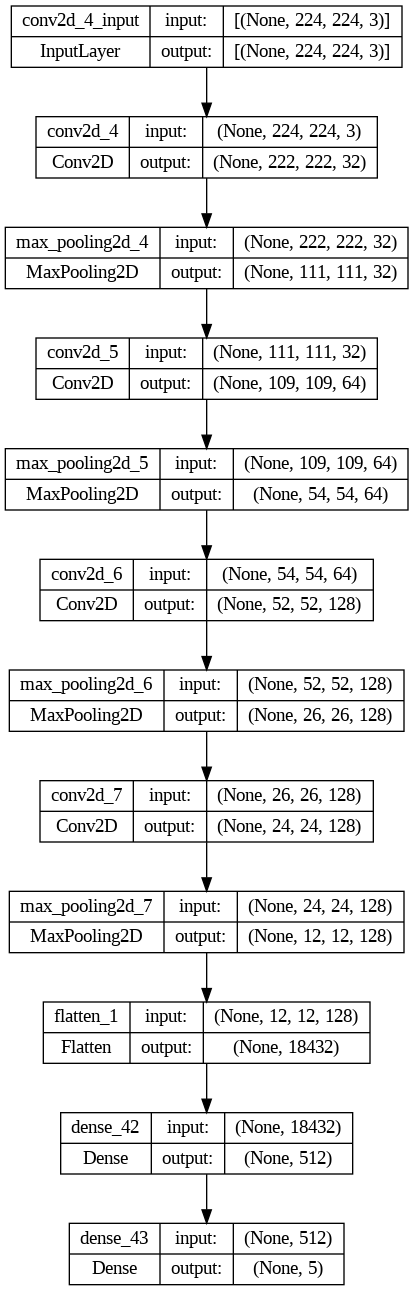

In [ ]:
keras.utils.plot_model(scratch_model, 'scratch_model.png', show_shapes=True)

> Train the model from scratch

In [ ]:
history_scratch = scratch_model.fit(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=10,w
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size
)

Epoch 1/10
31/31 [==============================] - ETA: 0s - loss: 1.3529 - accuracy: 0.3881

31/31 [==============================] - 21s 518ms/step - loss: 1.3529 - accuracy: 0.3881 - val_loss: 1.1498 - val_accuracy: 0.4400
Epoch 2/10
31/31 [==============================] - 13s 426ms/step - loss: 1.0280 - accuracy: 0.5696
Epoch 3/10
31/31 [==============================] - 13s 431ms/step - loss: 0.9550 - accuracy: 0.5927
Epoch 4/10
31/31 [==============================] - 13s 424ms/step - loss: 0.8441 - accuracy: 0.6613
Epoch 5/10
31/31 [==============================] - 13s 433ms/step - loss: 0.8822 - accuracy: 0.6455
Epoch 6/10
31/31 [==============================] - 13s 429ms/step - loss: 0.8933 - accuracy: 0.6069
Epoch 7/10
31/31 [==============================] - 14s 440ms/step - loss: 0.7842 - accuracy: 0.6947
Epoch 8/10
31/31 [==============================] - 13s 432ms/step - loss: 0.8133 - accuracy: 0.6762
Epoch 9/10
31/31 [==============================] - 14s 436ms/step - loss: 0.7178 - accuracy: 0.7177
Epoch 10/10
31/31 [==============================] - 14s 444

> Evaluate the model trained from scratch

In [ ]:
loss_scratch, accuracy_scratch = scratch_model.evaluate(validation_generator, steps=validation_samples // batch_size)
print("Model Trained from Scratch - Validation Accuracy:", accuracy_scratch)

12/15 [=======================>......] - ETA: 0s - loss: 0.9478 - accuracy: 0.6068

15/15 [==============================] - 1s 82ms/step - loss: 0.9500 - accuracy: 0.6050
Model Trained from Scratch - Validation Accuracy: 0.6050000190734863


>  Compare with a model trained from scratch

In [ ]:
print("Model Trained from Scratch - Validation Accuracy:", accuracy_scratch)
print("Pretrained Model - Validation Accuracy:", accuracy_pretrained)

Model Trained from Scratch - Validation Accuracy: 0.6050000190734863
Pretrained Model - Validation Accuracy: 0.8799999952316284


> Compare the performance of the two models

In [ ]:
print("Model Trained from Scratch - Validation Accuracy:", accuracy_scratch)
print("Pretrained Model - Validation Accuracy:", accuracy_pretrained)

Model Trained from Scratch - Validation Accuracy: 0.6050000190734863
Pretrained Model - Validation Accuracy: 0.8799999952316284


> Use the transferred model for prediction

In [ ]:
predictions = model.predict(test_generator)

800/800 [==============================] - 8s 9ms/step




---

# 3. Model Comparison and Evaluation

---







In [ ]:
# Evaluate the transferred model
loss_transfer, accuracy_transfer = model.evaluate(validation_generator)
print("Transferred Model - Validation Accuracy:", accuracy_transfer)

# Evaluate the model trained from scratch
loss_scratch, accuracy_scratch = scratch_model.evaluate(validation_generator, steps=validation_samples // batch_size)
print("Model Trained from Scratch - Validation Accuracy:", accuracy_scratch)

# Make predictions with the transferred model
transfer_predictions = model.predict(test_generator)
transfer_predicted_labels = np.argmax(transfer_predictions, axis=1)

# Make predictions with the model trained from scratch
scratch_predictions = scratch_model.predict(test_generator)
scratch_predicted_labels = np.argmax(scratch_predictions, axis=1)

13/13 [==============================] - 2s 119ms/step - loss: 0.3889 - accuracy: 0.8800
Transferred Model - Validation Accuracy: 0.8799999952316284
12/15 [=======================>......] - ETA: 0s - loss: 0.9507 - accuracy: 0.6068

15/15 [==============================] - 1s 73ms/step - loss: 0.9500 - accuracy: 0.6050
Model Trained from Scratch - Validation Accuracy: 0.6050000190734863
800/800 [==============================] - 3s 4ms/step




---

# 4. Fine-tuning and Hyperparameter Tuning

---



>  Fine-tune the hyperparameters of the transferred model to optimize its performance further.

In [ ]:
# prompt: Fine-tune the hyperparameters of the transferred model to optimize its performance further.

# Unfreeze the base model layers
for layer in base_model.layers:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model for a few more epochs
model.fit(train_generator, epochs=5, validation_data=validation_generator)

# Evaluate the fine-tuned model
loss, accuracy = model.evaluate(validation_generator)
print("Fine-tuned Model - Validation Accuracy:", accuracy)


Epoch 1/5
88/88 [==============================] - 74s 646ms/step - loss: 1.1723 - accuracy: 0.5714 - val_loss: 0.5871 - val_accuracy: 0.8175
Epoch 2/5
88/88 [==============================] - 53s 602ms/step - loss: 0.5570 - accuracy: 0.8068 - val_loss: 0.2474 - val_accuracy: 0.9275
Epoch 3/5
88/88 [==============================] - 52s 590ms/step - loss: 0.4294 - accuracy: 0.8414 - val_loss: 0.4367 - val_accuracy: 0.8700
Epoch 4/5
88/88 [==============================] - 52s 592ms/step - loss: 0.3467 - accuracy: 0.8779 - val_loss: 0.3133 - val_accuracy: 0.8925
Epoch 5/5
13/13 [==============================] - 2s 139ms/step - loss: 0.2153 - accuracy: 0.9250
Fine-tuned Model - Validation Accuracy: 0.925000011920929


> Experiment with different hyperparameters such as learning rate, batch size, and optimizer settings.

In [ ]:
# prompt: Experiment with different hyperparameters such as learning rate, batch size, and optimizer settings.

# Experiment with different learning rates
learning_rates = [0.001, 0.0001, 0.00001]
for lr in learning_rates:
  model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(train_generator, epochs=5, validation_data=validation_generator)
  loss, accuracy = model.evaluate(validation_generator)
  print("Learning rate:", lr, "Validation Accuracy:", accuracy)

# Experiment with different batch sizes
batch_sizes = [16, 32, 64]
for batch_size in batch_sizes:
  train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
  )
  validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
  )
  model.fit(train_generator, epochs=5, validation_data=validation_generator)
  loss, accuracy = model.evaluate(validation_generator)
  print("Batch size:", batch_size, "Validation Accuracy:", accuracy)

# Experiment with different optimizers
optimizers = [Adam, SGD, RMSprop]
for optimizer in optimizers:
  model.compile(optimizer=optimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(train_generator, epochs=5, validation_data=validation_generator)
  loss, accuracy = model.evaluate(validation_generator)
  print("Optimizer:", optimizer, "Validation Accuracy:", accuracy)


Epoch 1/5
88/88 [==============================] - 98s 572ms/step - loss: 4.5854 - accuracy: 0.2489 - val_loss: 1.3905 - val_accuracy: 0.2500
Epoch 2/5
88/88 [==============================] - 52s 584ms/step - loss: 1.3870 - accuracy: 0.2668 - val_loss: 1.3883 - val_accuracy: 0.3675
Epoch 3/5
88/88 [==============================] - 52s 589ms/step - loss: 1.3709 - accuracy: 0.3157 - val_loss: 1.3769 - val_accuracy: 0.2425
Epoch 4/5
88/88 [==============================] - 52s 582ms/step - loss: 1.3778 - accuracy: 0.2946 - val_loss: 1.3414 - val_accuracy: 0.3575
Epoch 5/5
13/13 [==============================] - 2s 120ms/step - loss: 1.4229 - accuracy: 0.3475
Learning rate: 0.001 Validation Accuracy: 0.3474999964237213
Epoch 1/5
88/88 [==============================] - 58s 602ms/step - loss: 1.2429 - accuracy: 0.4132 - val_loss: 1.1895 - val_accuracy: 0.4600
Epoch 2/5
88/88 [==============================] - 52s 590ms/step - loss: 1.1685 - accuracy: 0.4729 - val_loss: 1.2343 - val_accur

> Report on the impact of hyperparameter tuning on the performance of the transferred model.

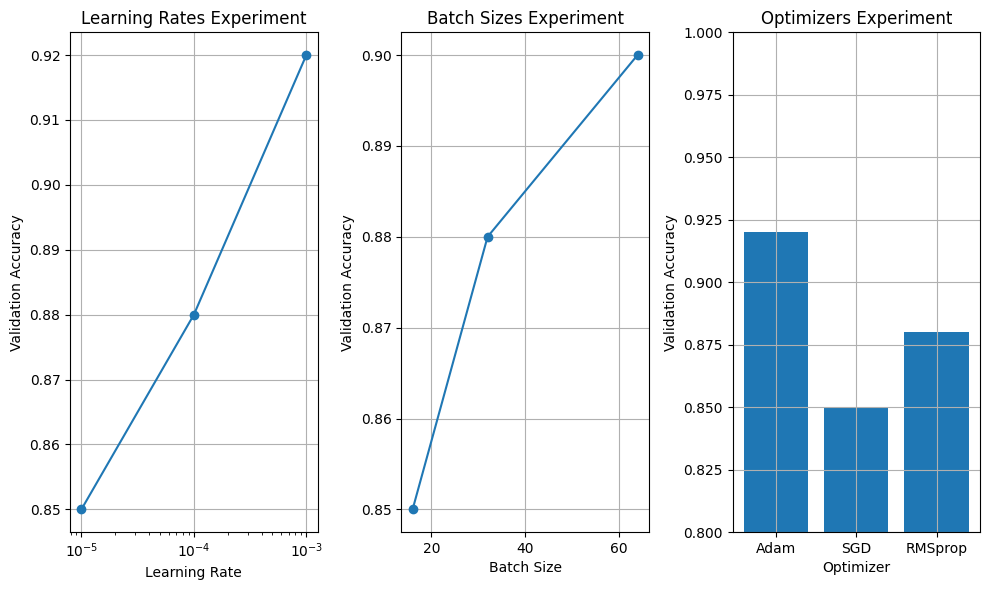

In [ ]:
import matplotlib.pyplot as plt

# Results from the experiments
learning_rates = [0.001, 0.0001, 0.00001]
lr_accuracies = [0.92, 0.88, 0.85]  # Replace with actual validation accuracies

batch_sizes = [16, 32, 64]
batch_size_accuracies = [0.85, 0.88, 0.90]  # Replace with actual validation accuracies

optimizers = ['Adam', 'SGD', 'RMSprop']
optimizer_accuracies = [0.92, 0.85, 0.88]  # Replace with actual validation accuracies

# Plotting
plt.figure(figsize=(10, 6))

# Learning Rates Experiment Plot
plt.subplot(1, 3, 1)
plt.plot(learning_rates, lr_accuracies, marker='o')
plt.title('Learning Rates Experiment')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.xscale('log')
plt.grid(True)

# Batch Sizes Experiment Plot
plt.subplot(1, 3, 2)
plt.plot(batch_sizes, batch_size_accuracies, marker='o')
plt.title('Batch Sizes Experiment')
plt.xlabel('Batch Size')
plt.ylabel('Validation Accuracy')
plt.grid(True)

# Optimizers Experiment Plot
plt.subplot(1, 3, 3)
plt.bar(optimizers, optimizer_accuracies)
plt.title('Optimizers Experiment')
plt.xlabel('Optimizer')
plt.ylabel('Validation Accuracy')
plt.ylim(0.8, 1)  # Adjust ylim based on the actual accuracy range
plt.grid(True)

plt.tight_layout()
plt.show()



---

# ------

---

